<a href="https://colab.research.google.com/github/duper203/upstage_cookbook/blob/main/from_togetherai/Semantic_Search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Semantic Searching for Movies
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/togethercomputer/together-cookbook/blob/main/Semantic_Search.ipynb)

## Introduction

In this notebook we will implement semantic search feature over a dataset of movies. Given a user `query` we'd like to identify movies that user might be interested in. In order to do this we need to be able to search through a dataset of 1000's (or even more!) of movies and rank each one based on it's semantic relevance to the user query.  

To do this we will follow these steps:
1. Embed our entire movies dataset, which is a subset of the [Movies Dataset](https://www.kaggle.com/datasets/utkarshx27/movies-dataset). This will produce a vector representation of each movie.
2. Upon recieving a user `query` we will embed this using the same model. This will produce a query vector.
3. We will measure the distance between the query vector and each movie vector. Sorting this list will give us movies most semantically similar to the query!
4. We can return the list of the top K movies the user might be interested in.  

<img src="https://github.com/togethercomputer/together-cookbook/blob/main/images/semantic_search.png?raw=1" width="750">

### Install relevant libraries

In [ ]:
!pip install -qU openai langchain-upstage

In [2]:
import os
from google.colab import userdata
os.environ["UPSTAGE_API_KEY"] = userdata.get("UPSTAGE_API_KEY")

### Download and View the Dataset

In [3]:
# Let's get the movies dataset
!wget https://raw.githubusercontent.com/togethercomputer/together-cookbook/refs/heads/main/datasets/movies.json
!mkdir datasets
!mv movies.json datasets/movies.json

--2024-10-24 19:28:15--  https://raw.githubusercontent.com/togethercomputer/together-cookbook/refs/heads/main/datasets/movies.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 461845 (451K) [text/plain]
Saving to: ‘movies.json’

movies.json         100%[===================>] 451.02K  --.-KB/s    in 0.05s   

2024-10-24 19:28:15 (8.91 MB/s) - ‘movies.json’ saved [461845/461845]



In [7]:
import json

with open('./datasets/movies.json', 'r') as file:
    movies_data = json.load(file)

movies_data[:3]

[{'title': 'Minions',
  'overview': 'Minions Stuart, Kevin and Bob are recruited by Scarlet Overkill, a super-villain who, alongside her inventor husband Herb, hatches a plot to take over the world.',
  'director': 'Kyle Balda',
  'genres': 'Family Animation Adventure Comedy',
  'tagline': 'Before Gru, they had a history of bad bosses'},
 {'title': 'Interstellar',
  'overview': 'Interstellar chronicles the adventures of a group of explorers who make use of a newly discovered wormhole to surpass the limitations on human space travel and conquer the vast distances involved in an interstellar voyage.',
  'director': 'Christopher Nolan',
  'genres': 'Adventure Drama Science Fiction',
  'tagline': 'Mankind was born on Earth. It was never meant to die here.'},
 {'title': 'Deadpool',
  'overview': 'Deadpool tells the origin story of former Special Forces operative turned mercenary Wade Wilson, who after being subjected to a rogue experiment that leaves him with accelerated healing powers, ado

### 1. Generate Embeddings

We will use the Together AI embedding API to generate vector representations for each movie `title` + `overview` + `tagline`.

In [8]:
# This function will be used to access the Upstage Embedding API to generate embeddings for the movie plots

from typing import List
import numpy as np
from langchain_upstage import UpstageEmbeddings


def generate_embeddings(input_texts: List[str]) -> List[List[float]]:
    """Generate embeddings from Together python library.

    Args:
        input_texts: a list of string input texts.
        model_api_string: str. An API string for a specific embedding model of your choice.

    Returns:
        embeddings_list: a list of embeddings. Each element corresponds to the each input text.
    """
    embeddings = UpstageEmbeddings(model="solar-embedding-1-large")
    embed_list = embeddings.embed_documents(input_texts)
    return embed_list

In [9]:
# Concatenate the title, overview, and tagline of each movie
# this makes the text that will be embedded for each movie more informative
# as a result the embeddings will be richer and capture this information.
to_embed = []
for movie in movies_data[:1000]:
    text = ''
    for field in ['title', 'overview', 'tagline']:
        value = movie.get(field, '')
        text += str(value) + ' '
    to_embed.append(text.strip())

to_embed[:10]

['Minions Minions Stuart, Kevin and Bob are recruited by Scarlet Overkill, a super-villain who, alongside her inventor husband Herb, hatches a plot to take over the world. Before Gru, they had a history of bad bosses',
 'Interstellar Interstellar chronicles the adventures of a group of explorers who make use of a newly discovered wormhole to surpass the limitations on human space travel and conquer the vast distances involved in an interstellar voyage. Mankind was born on Earth. It was never meant to die here.',
 'Deadpool Deadpool tells the origin story of former Special Forces operative turned mercenary Wade Wilson, who after being subjected to a rogue experiment that leaves him with accelerated healing powers, adopts the alter ego Deadpool. Armed with his new abilities and a dark, twisted sense of humor, Deadpool hunts down the man who nearly destroyed his life. Witness the beginning of a happy ending',
 'Guardians of the Galaxy Light years from Earth, 26 years after being abducted,

In [10]:
embeddings = generate_embeddings(to_embed)

In [11]:
# Check the shape of each vector embedding to make sure it is 4096 dimensions
len(embeddings[0])

4096

### What does a movie vector "look" like?

Here we visualize the vector representation the `bge-base-en-v1.5` produced for the Minions movie at index 0!

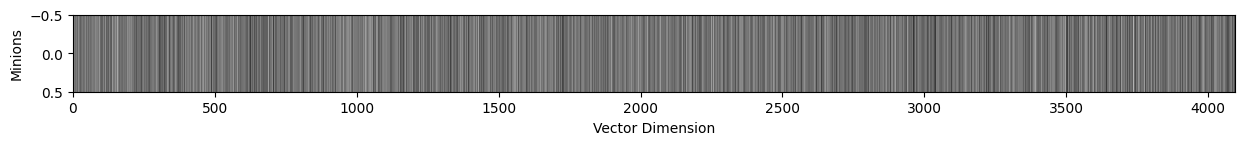

In [13]:
import matplotlib.pyplot as plt
import numpy as np

data = embeddings[0]

data_2d = np.reshape(data, (1, 4096))

plt.figure(figsize=(15, 1))
# Create a heatmap with a binary colormap (black and white)
plt.imshow(data_2d, cmap='binary', interpolation='nearest', aspect='auto')

# Remove axes and ticks
plt.xlabel('Vector Dimension')
plt.ylabel(f"{movies_data[0]['title']}")
# Show the plot
plt.show()

A single vector looks alot like a barcode!

In the plot above you can ignore the `y-axis`. The `x-axis` captures each dimension of the 4096 dimensional vector, the colour captures the values at each dimension.

Let's visualize some more vectors to see if we can find patterns!

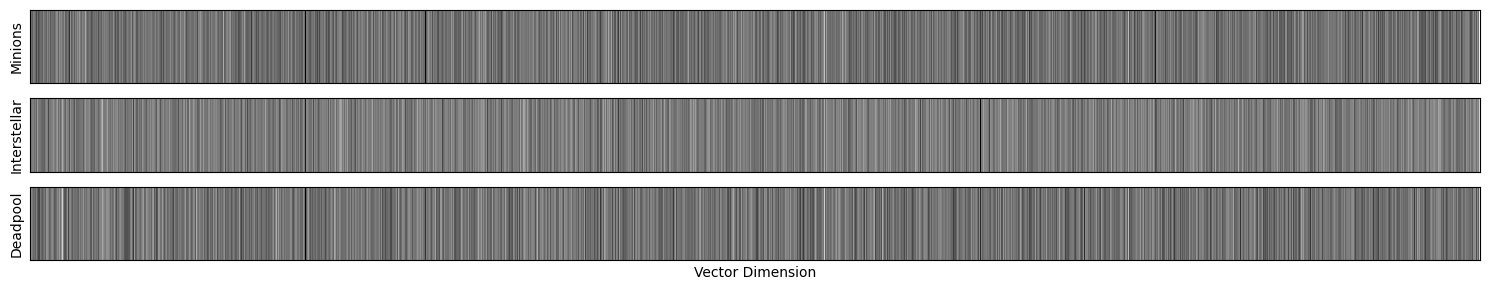

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Select three movie embeddings
data1 = embeddings[0]
data2 = embeddings[1]
data3 = embeddings[2]

# Reshape each embedding into a 2D array
data1_2d = np.reshape(data1, (1, 4096))
data2_2d = np.reshape(data2, (1, 4096))
data3_2d = np.reshape(data3, (1, 4096))

# Create a figure with three subplots
fig, axs = plt.subplots(3, 1, figsize=(15, 3))

# Plot each embedding as a heatmap
axs[0].imshow(data1_2d, cmap='binary', interpolation='nearest', aspect='auto')
axs[1].imshow(data2_2d, cmap='binary', interpolation='nearest', aspect='auto')
axs[2].imshow(data3_2d, cmap='binary', interpolation='nearest', aspect='auto')

# Set labels and titles
axs[0].set_ylabel(f"{movies_data[0]['title']}")
axs[1].set_ylabel(f"{movies_data[1]['title']}")
axs[2].set_ylabel(f"{movies_data[2]['title']}")
axs[2].set_xlabel('Vector Dimension')

# Remove ticks
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

# Layout so plots do not overlap
fig.tight_layout()

# Show the plot
plt.show()

The vectors for the three movies above capture the semantics of the movie title + overview + tagline!

When trying to understand what a vector looks like it better to look at the overall pattern of the barcode as opposed to asking what each line in the barcode means. Each line in the barcode might not have a human understandable meaning - experts don't yet understand how each bar contributes to capturing the overall meaning of the movie!

Next let's visualize the user query!

## 2. Vectorize the User Query

In this case the user is interested in `query` = `super hero action movie with a timeline twist` and so we want to rank our dataset of 1000 movies such that relevant movies are at the top of the list we send to this user.

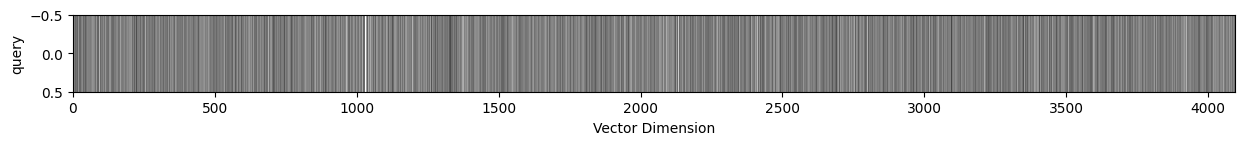

In [17]:
query = "super hero action movie with a timeline twist"

query_embedding = generate_embeddings([query])[0]

data_2d = np.reshape(query_embedding, (1, 4096))

plt.figure(figsize=(15, 1))
# Create a heatmap with a binary colormap (black and white)
plt.imshow(data_2d, cmap='binary', interpolation='nearest', aspect='auto')

# Remove axes and ticks
plt.xlabel('Vector Dimension')
plt.ylabel("query")
# Show the plot
plt.show()

The `query` vector also looks like a barcode.

The problem of solving which movie is most semantically similar to the user query is the same as asking which movie vector/barcode "looks" most similar to the query vector/barcode!

## 3. Compute Distance between Query and Movie Vectors

Here we will use the cosine similarity metric to identify which movie vectors are closest to the query vector. Intuitively think of this step as matching the qeury barcode to the movie barcodes to find the best match!

In [18]:
from sklearn.metrics.pairwise import cosine_similarity

# This function will produce a list of cosine similarity scores between the query embedding and the movie embeddings
similarity_scores = cosine_similarity([query_embedding], embeddings)

In [19]:
# We get a cosine similarity score for each one of the 1000 movie embeddings
similarity_scores.shape

(1, 1000)

In [20]:
# Cosine similarity goes from -1 to 1, where 1 means the vectors are identical and -1 means they are opposite.
similarity_scores[0, :10]

array([0.41844285, 0.42472354, 0.46951252, 0.4608487 , 0.42757719,
       0.3680335 , 0.44847033, 0.42090551, 0.41408895, 0.4494984 ])

## 4. Sort Movies based on Semantic Similarity

We want to organize our list of 1000 movies from most to least relevant to the query. We can do this by sorting the above `similarity_scores` array.

In [21]:
# Get the indices of the highest to lowest cosine similarity values
# This tell use which movies are most similar to the query

# Lookin at the results below we see that the movie at index 172 is the most similar to the query!
indices = np.argsort(-similarity_scores)

print(indices)

[[977  49 535 227 187  52  76 590 319 185 834 265  17 349 944 701 490 613
  723 812 295 366  36 195 328  94 174 973 188 543 372 217 487 268 291 924
  115 374 519 530 191 524 149  22 990 131 119 815 145 211 546 180 788 952
  312 305 344 688 828  11 542 204 822  50 842 176 585 827 358 638   2 224
  871 209 768 865 474 904  18 321 626 750  67  47  25 890  55 893 515 472
  752  93  58 116 867 429   3 296 839 482  28 205 943 661 400 325 170 927
  655 129 147 468 690 595  20 222 166 425 197 912 424 964 420  60 580 555
  285 999 570 920 238  13 385 106 766 683 606 203 317 844 206 915 820   9
  173 783  87 478  62 900   6 331 737 773 501 214  26 991 495 477 357 817
  636 676 292  33 263 997 394 862 172  38 681 777 467 908 816 938 669 658
  184 298 343 730 199 347 308 759 365 813 940 207  81 460 706 194 969 406
  526 680 231 615 163 335 450 627 497 961 949 966 511 288 430 134 463 560
  726 650 941 252 675 897 632 419  35 592 761 573 821 376 527 500 677 946
  746 462  98 891 795 621 648 599 600 

In [22]:
top_10_sorted_titles = [movies_data[index]['title'] for index in indices[0]][:10]

top_10_sorted_titles

['Project Almanac',
 'Iron Man',
 'Looper',
 'Megamind',
 'Captain America: The First Avenger',
 'X-Men: Days of Future Past',
 'The Matrix',
 'Knight and Day',
 'The Curious Case of Benjamin Button',
 'About Time']

Here we can see the list of top ten movies most similar to the query(`super hero action movie with a timeline twist`), according to vector embeddings.
Notice that most of these movies have something to do with the query. Some are super hero movies, some are action movies and others have a timeline twist - we get very few false positives(movies that have nothing to do with anything in the query).

Semantic similarity gives us a fuzzy way to sort our dataset based on how similar the objects are to a given query!
